In [1]:
import mtrf
import numpy as np
import librosa
import scipy
import mne
import matplotlib.pyplot as plt
from mtrf.stats import pearsonr, neg_mse

In [2]:
#load data

X = np.load('X.npy')
y = np.load('y.npy')
att = np.load('attended.npy')
mas = np.load('masker.npy')

In [85]:
# Number of samples per participant
datapoints = 80

In [210]:
#Load data, normalize it and find the envelope

def resample_envelope(filename):
    wav,sfreq = librosa.load(filename,sr=None)
    wav = np.abs(scipy.signal.hilbert(wav))
    data = scipy.signal.resample_poly(wav,up = 128, down = sfreq)
    data = np.asarray(data,np.float64)
    #data = (data - data.mean())/data.std()
    data = mne.filter.filter_data(data,128,1,30,verbose=False)
    return data

In [211]:
#Choose Fifth subject

id = 9
n = 1

In [212]:
def standardize(x):
    x = (x-np.mean(x))/np.std(x)
    return x

In [314]:
eeg = X[datapoints*id:datapoints*(id+n),:,5*128:38*128]

attended = list(map(resample_envelope,att[datapoints*id:datapoints*(id+n)]))

masker = list(map(resample_envelope,mas[datapoints*id:datapoints*(id+n)]))

In [315]:
attended = list(map(standardize,attended))
masker = list(map(standardize,masker))

for i in range(len(eeg)):
    eeg[i] = (eeg[i]-np.expand_dims(np.mean(eeg[i],axis=1),axis=-1))/np.expand_dims(np.std(eeg[i],axis=1),axis=-1)

In [316]:
eeg = eeg.transpose((0,2,1))

In [12]:
regularization = np.logspace(-1, 6, 10)

In [348]:
btrf = mtrf.TRF(direction=-1,metric=pearsonr,method='tikhonov')

In [349]:
mse = btrf.train(list(attended[0:40]),list(eeg[0:40]),fs=128,tmin=-0.3,tmax=0.2,regularization = 10,verbose=True)

In [350]:
pred, r = btrf.predict(list(attended[40:80]),list(eeg[40:80]))

In [351]:
def predict(pred,attended,masker):
    total = 0
    for i in range(len(pred)):
        #pred[i] = standardize(pred[i])
        peara = scipy.stats.pearsonr(np.squeeze(pred[i]),np.squeeze(attended[i]))
        pearm = scipy.stats.pearsonr(np.squeeze(pred[i]),np.squeeze(masker[i]))
        if peara>pearm:
            total+=1
    return (total/len(pred))*100

In [352]:
result = predict(pred,attended[40:80],masker[40:80])

In [353]:
result

45.0

In [323]:
r

-0.0073408713508190645

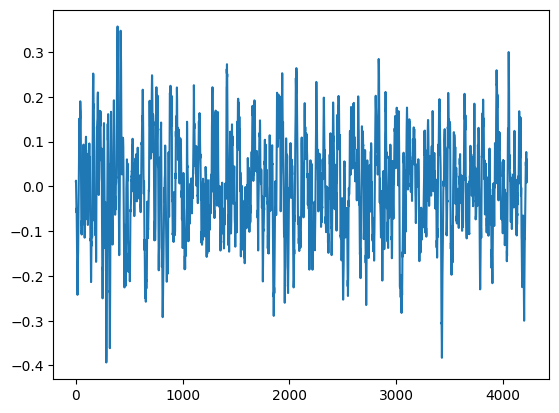

In [354]:
plt.plot(pred[0])

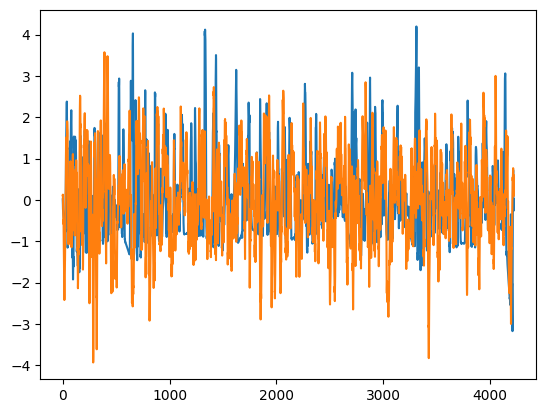

In [356]:
plt.plot(attended[0])
plt.plot(pred[0]*10)

In [313]:
len(attended[0])

4224

In [326]:
from mtrf.model import load_sample_data

stimulus, response, fs = load_sample_data(n_segments=10, normalize=True)

In [327]:
tmin, tmax = 0, 0.4  # range of time lag
regularization = 1000 # regularization parameter lambda

In [335]:
envelope = [s.mean(axis=1) for s in stimulus]
bwd_trf = mtrf.TRF(direction=-1)
r_bwd = bwd_trf.train(envelope, response, fs, tmin, tmax, regularization)
r_bwd = mtrf.stats.crossval(bwd_trf, envelope, response, fs, tmin, tmax, regularization)
print(f"correlation between actual and predicted envelope: {r_bwd.round(3)}")

Cross-validating[##################################################] 10/10

correlation between actual and predicted envelope: 0.117


In [337]:
pred, r = bwd_trf.predict(envelope,response)

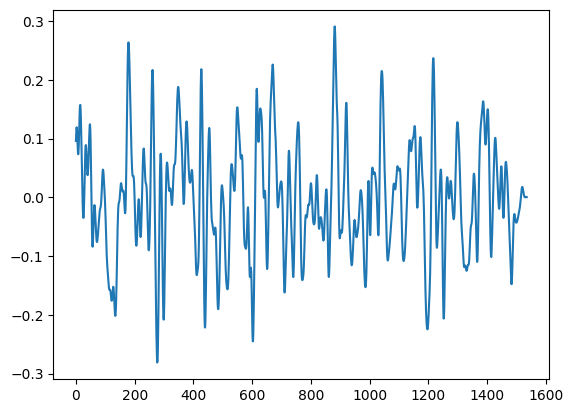

In [338]:
plt.plot(pred[0])

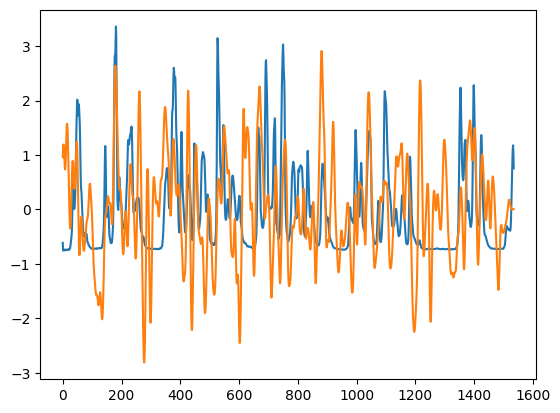

In [341]:
plt.plot(envelope[0])
plt.plot(pred[0]*10)